In [27]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_selector,make_column_transformer,ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif,SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from scipy.stats import uniform, randint
from sklearn import tree
import plotly.express as px

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
demos = pd.read_csv(r'synthetic_data\demos.csv')
dispositions = pd.read_csv(r'synthetic_data\dispositions.csv')
email_sends = pd.read_csv(r'synthetic_data\email_sends.csv')

In [30]:
dispositions.rename(columns = {'timets':'days_since_handraise'}, inplace = True)
email_sends.rename(columns = {'timets':'days_since_email_engg'}, inplace = True)

In [31]:
merged_df = demos.merge(dispositions, how='inner', on='id')

In [32]:
received_email_engg = email_sends['id'].unique()
opened_email_engg = email_sends[email_sends['opened'] == 1]['id'].unique()

In [33]:
merged_df['received_email_engagement'] = merged_df['id'].apply(lambda x: 1 if x in received_email_engg else 0)
merged_df['opened_email_engagement'] = merged_df['id'].apply(lambda x: 1 if x in opened_email_engg else 0)

In [34]:
df = merged_df.copy()

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   gender                     449979 non-null  object
 1   education                  496589 non-null  object
 2   income                     496726 non-null  object
 3   residence_type             500000 non-null  object
 4   children                   500000 non-null  object
 5   marital_status             496714 non-null  object
 6   numb_of_vehicles           500000 non-null  object
 7   age                        496607 non-null  object
 8   voi_type                   500000 non-null  object
 9   job_industry               500000 non-null  object
 10  fear_of_tech               500000 non-null  object
 11  years_in_workforce         500000 non-null  object
 12  driver_type                500000 non-null  object
 13  type_of_spender            500000 non-null  

In [36]:
# Define the mappings for ordinal encoding
gender_mapping = ['Female', 'Male']
edu_mapping = ['less than HS', 'High School', 'Junior College', 'Bachelors', "Master's", 'PhD']
sal_mapping = ['< 20 k', '30K - 40K', '40K - 50K', '50K - 60K', "70K - 80K", '80K - 90K', '>100K']
children_mapping = ['No Children', '1 Child', 'Two or more Children']
age_mapping = ['<=18', '19 - 24', '25-30', '30-40', "40-50", '60+']
no_veh_mapping = ['No vehicles', '1 Vehicle', '2 or more vehicles']
yrs_mapping = ['0 - 1', '1 - 2', '2 - 3', '3 - 4', "4 - 5", '5+']
brand_int_mapping = ['heard of the brand', 'purhcased from brand before', 'love the brand']

# Create one-hot encoder and ordinal encoder
ordinal_categories = [gender_mapping, edu_mapping, sal_mapping,age_mapping,children_mapping,no_veh_mapping, yrs_mapping,brand_int_mapping]

si = SimpleImputer(strategy='most_frequent')

columns_for_ordinal_encoding = ['gender', 'education', 'income', 'age', 'children', 'numb_of_vehicles', 'years_in_workforce', 'brand_interest']
columns_for_one_hot_encoding = ['residence_type', 'marital_status', 'voi_type', 'job_industry', 'fear_of_tech', 'driver_type', 'type_of_spender']

In [37]:
#creating pipeline for ordinal and nominal cat features 

cat_ordinal_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=ordinal_categories)
    )

cat_nominal_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown="ignore")
    )

preprocessor = make_column_transformer(
    (cat_ordinal_transformer, columns_for_ordinal_encoding),
    (cat_nominal_transformer, columns_for_one_hot_encoding),
    remainder='passthrough'
)

In [38]:
X = df.drop(['y'],axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [39]:
feature_selector = SelectKBest(mutual_info_classif, k=20)
rfc = RandomForestClassifier(random_state=42)

In [40]:
pipeline1 = make_pipeline(preprocessor,feature_selector,rfc)

In [65]:
cross_val_score(pipeline1,X_train,y_train,cv=5,scoring='accuracy').mean()

0.6176626865671642

In [81]:
params = {
    'randomforestclassifier__n_estimators': randint(100,1000),
    'randomforestclassifier__max_depth': randint(10,100),
    'randomforestclassifier__min_samples_split': randint(8,12),
    'randomforestclassifier__min_samples_leaf': randint(3,8)
}

In [58]:
rfc_grid = RandomizedSearchCV(pipeline1,params,n_iter=10,cv=5,n_jobs=-1,scoring='accuracy',random_state=42)
rfc_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ordinalencoder',
                                                                                                OrdinalEncoder(categories=[['Female',
                                                                                                                            'Male'],
                                                                                                                           ['less '
                                                                                                                            'than '
                                                                                                                            'HS',
                                                                                                                            'High '
                                                                                                                            'School',
                                                                                                                            'Junior '
                                                                                                                            'College',
                                                                                                                            'Bachelors',
                                                                                                                            "Master's...
                                              RandomForestClassifier(max_depth=20,
                                                                     min_samples_leaf=3,
                                                                     min_samples_split=9,
                                                                     random_state=42))]),
                   param_distributions={'randomforestclassifier__max_depth': [10,
                                                                              50,
                                                                              100],
                                        'randomforestclassifier__min_samples_leaf': [3,
                                                                                     5,
                                                                                     8],
                                        'randomforestclassifier__min_samples_split': [8,
                                                                                      10,
                                                                                      12],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 500,
                                                                                 1000]},
                   random_state=42, scoring='accuracy')

In [59]:
rfc_grid.best_score_

0.622265671641791

In [60]:
rfc_grid.best_params_

{'randomforestclassifier__n_estimators': 500,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 8,
 'randomforestclassifier__max_depth': 10}

In [61]:
best_model = rfc_grid.best_estimator_
y_pred = best_model.predict(X_test)

In [62]:
accuracy_score(y_test,y_pred)

0.6223212121212122

In [63]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.66      0.62     76808
           1       0.66      0.59      0.63     88192

    accuracy                           0.62    165000
   macro avg       0.62      0.62      0.62    165000
weighted avg       0.63      0.62      0.62    165000



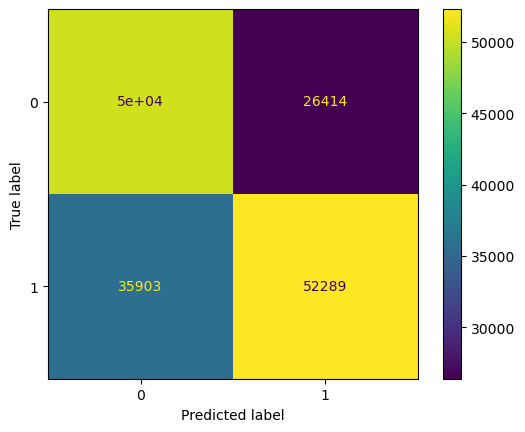

In [64]:
# Calculate the confusion matrix
conf_matrix_rfc = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix_rfc).plot()

In [66]:
# Create the ColumnTransformer

hgbc_preprocessing = make_column_transformer( 
        (OrdinalEncoder(categories=ordinal_categories,
                        handle_unknown='use_encoded_value',
                        unknown_value=np.nan),columns_for_ordinal_encoding),  # Ordinal encode specified columns
        (OneHotEncoder(handle_unknown="ignore"), columns_for_one_hot_encoding),  # One-hot encode specified columns
    remainder='passthrough'  # Passthrough any other columns not specified above
)

In [67]:
hgbc = HistGradientBoostingClassifier(random_state=42)
pipeline2 = make_pipeline(hgbc_preprocessing,hgbc)

In [68]:
cross_val_score(pipeline2,X_train,y_train,cv=5,scoring='accuracy').mean()

0.6255731343283581

In [91]:
params_1 = {
    'histgradientboostingclassifier__max_iter': randint(100, 1000),
    'histgradientboostingclassifier__max_depth': randint(10, 100),
    'histgradientboostingclassifier__max_leaf_nodes': [None, 30, 60, 90],
    'histgradientboostingclassifier__min_samples_leaf': randint(3, 8)
}

In [92]:
hgbc_grid = RandomizedSearchCV(pipeline2,params_1,n_iter=10,cv=5,n_jobs=-1,scoring='accuracy',random_state=42)
hgbc_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['Female',
                                                                                                           'Male'],
                                                                                                          ['less '
                                                                                                           'than '
                                                                                                           'HS',
                                                                                                           'High '
                                                                                                           'School',
                                                                                                           'Junior '
                                                                                                           'College',
                                                                                                           'Bachelors',
                                                                                                           "Master's",
                                                                                                           'PhD'],
                                                                                                          ['< '
                                                                                                           '20 '
                                                                                                           'k',
                                                                                                           '30K '
                                                                                                           '- '
                                                                                                           '40K',
                                                                                                           '40K '
                                                                                                           '- '
                                                                                                           '50K',
                                                                                                           '50K '
                                                                                                           '- '
                                                                                                           '60K',
                                                                                                           '70K '
                                                                                                           '- '
                                                                                                           '80K',
                                                                                                           '80K '
                                                                                                           '- '
                                                                                                           '90...
                                        'histgradientboostingclassifier__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001760E2DEFF0>,
                                        'histgradientboostingclassifier__max_leaf_nodes': [None,
                      

In [93]:
hgbc_grid.best_score_

0.6254865671641792

In [94]:
hgbc_grid.best_params_

{'histgradientboostingclassifier__max_depth': 31,
 'histgradientboostingclassifier__max_iter': 408,
 'histgradientboostingclassifier__max_leaf_nodes': 30,
 'histgradientboostingclassifier__min_samples_leaf': 6}

In [96]:
best_model = rfc_grid.best_estimator_
hgbc_y_pred = best_model.predict(X_test)

In [97]:
accuracy_score(y_test,hgbc_y_pred)

0.6223212121212122

In [98]:
print("Classification Report:\n", classification_report(y_test, hgbc_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.66      0.62     76808
           1       0.66      0.59      0.63     88192

    accuracy                           0.62    165000
   macro avg       0.62      0.62      0.62    165000
weighted avg       0.63      0.62      0.62    165000



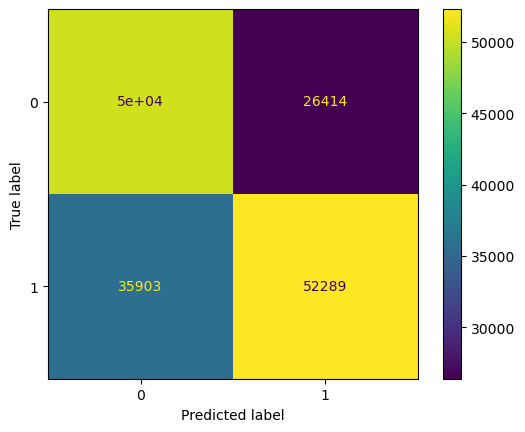

In [99]:
# Calculate the confusion matrix
conf_matrix_rfc = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix_rfc).plot()